# MLAI Portfolio project - Energy consumption prediction using ASHRAE Kaggle competition dataset

_Author: Ben Chichester_

## Preamble
For my portfolio project I've chosen a dataset comprising of electricity consumption data monitored over ~1500 buildings. This is similar to datasets I'd like to analyse at work, exploring ways to predict energy usage. The purpose here was not an advanced optimisation of the prediction problem, but to instead personally learn to use some techniques introduced in the training course that might be applicable to energy data in general and understand the performance differences. I hope to expand on this work over time, learning techniques more applicable to time series. 

**Section A** covers data preprocessing and cleaning, which is largely taken from the Kaggle competition. I have learned a great deal of Python from this exercise! 

**Section B** covers machine learning material, where I prepare the data to be similar to my industry use-case, then try decision trees and random forests to predict random hours of energy consumption. 

## A. Preprocessing
Overarching preprocessing steps of https://www.kaggle.com/code/corochann/optuna-tutorial-for-hyperparameter-optimization/notebook: 
1. Functions to reduce memory usage of data files. These are used later in data preparation to reduce the memory usage of dataframes after data preparation. SaveAsFeather.ipynb ran prior to this notebook to reduce the memory usage of the datafiles downloaded from the Kaggle competition. This drastically increased my options of what I could do with the data on my personal laptop. 

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree, ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Loading data and pre-preparation
Load feather formats for training data:

In [3]:
%%time
root = Path('Capstone/Portfolio/ashrae-energy-prediction')

train_df = pd.read_feather(root/'train.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

CPU times: user 330 ms, sys: 269 ms, total: 599 ms
Wall time: 277 ms


Timestamp is split into hour, day of the week, boolean for weekend, and month. Many users in the competition take the natural logarithm of the meter readings. Data exploration by users found that meter '0' until May for building IDs <105 were zeroed, so here I remove these with an anti-query. 

Finally, buildings are grouped and some simple statistics is saved for each building that may be useful later. 

In [4]:
# Preprocessing
def add_datetimes(df):
    df["hour"] = df["timestamp"].dt.hour
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["weekend"] = df["dayofweek"] >= 5

train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

add_datetimes(train_df)

df_group = train_df.groupby(['building_id', 'meter'])['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

In [5]:
building_stats_df = pd.concat([building_mean, building_median, building_min, building_max, building_std], axis=1,
                              keys=['building_mean', 'building_median', 'building_min', 'building_max', 'building_std']).reset_index()
train_df = pd.merge(train_df, building_stats_df, on=['building_id', 'meter'], how='left', copy=False)

In [6]:
train_df.head()

,building_id,meter,timestamp,meter_reading,date,meter_reading_log1p,hour,month,dayofweek,weekend,building_mean,building_median,building_min,building_max,building_std
0,105,0,2016-01-01,23.303600,2016-01-01,3.190624,0,1,4,False,4.316406,4.332031,3.191406,5.164062,0.318115
1,106,0,2016-01-01,0.374600,2016-01-01,0.318163,0,1,4,False,0.751953,0.559082,0.000000,2.890625,0.478516
2,106,3,2016-01-01,0.000000,2016-01-01,0.000000,0,1,4,False,1.023438,0.000000,0.000000,3.712891,1.268555
3,107,0,2016-01-01,175.184006,2016-01-01,5.171529,0,1,4,False,4.570312,5.781250,0.039703,6.382812,2.009766
4,108,0,2016-01-01,91.265297,2016-01-01,4.524668,0,1,4,False,5.457031,5.449219,4.417969,6.113281,0.216187


### Weather data
There are lots of NaNs in the weather data!

In [7]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

We interpolate shortly. First, we must align the weather's timestamps after many users in the competition realised that the weather data was using a different clock to the meter data (depending on which time zone the building is in!). 

This is done by lining up the maximum temperature in time to 14:00 hours (a rough approximation of when it should occur). 

In [8]:
weather_test_df = pd.read_feather(root/'weather_test.feather')
weather = pd.concat([weather_train_df, weather_test_df],ignore_index=True)
del weather_test_df
weather_key = ['site_id', 'timestamp']

In [9]:
# From https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type

temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()

# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

del weather
del temp_skeleton
gc.collect()

23

Perform the alignment function and finally interpolate to remove NaNs:

In [10]:
# Align timestamp
weather_train_df = timestamp_align(weather_train_df)

# Interpolate to remove nans
for col in weather_train_df.columns[2:-1]:
    weather_train_df[col] = weather_train_df.groupby('site_id').apply(lambda group: group[[col]].interpolate(limit_direction='both'))

Not covered here, but a future assignment for myself is to implement lagged features, which is quite an important concept for time series analyses.

In [ ]:
# def add_lag_feature(weather_df, window=3):
#     group_df = weather_df.groupby('site_id')
#     cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
#     rolled = group_df[cols].rolling(window=window, min_periods=0)
#     lag_mean = rolled.mean().reset_index().astype(np.float16)
#     lag_max = rolled.max().reset_index().astype(np.float16)
#     lag_min = rolled.min().reset_index().astype(np.float16)
#     lag_std = rolled.std().reset_index().astype(np.float16)
#     for col in cols:
#         weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
#         weather_df[f'{col}_max_lag{window}'] = lag_max[col]
#         weather_df[f'{col}_min_lag{window}'] = lag_min[col]
#         weather_df[f'{col}_std_lag{window}'] = lag_std[col]

# add_lag_feature(weather_train_df, window=3)
# add_lag_feature(weather_train_df, window=72)

### Categorising 
Categorise the primary_use column to reduce memory on merge (rather than get_dummies as we've learned in the training course):

In [11]:
primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [12]:
reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1326.46 MB
Memory usage after optimization is: 795.89 MB
Decreased by 40.0%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 24.2%
Memory usage of dataframe is 6.00 MB
Memory usage after optimization is: 3.20 MB
Decreased by 46.7%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,offset
0,0,2015-12-31 19:00:00,25.000000,6.0,20.000000,-1.0,1019.5,0.0,0.000000,5
1,0,2015-12-31 20:00:00,24.406250,4.0,21.093750,-1.0,1020.0,70.0,1.500000,5
2,0,2015-12-31 21:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000,5
3,0,2015-12-31 22:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000,5
4,0,2015-12-31 23:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609,5
...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 13:00:00,3.000000,1.5,-8.000000,-1.0,1007.5,180.0,5.699219,6
139769,15,2016-12-31 14:00:00,2.800781,2.0,-8.898438,-1.0,1007.5,180.0,7.699219,6
139770,15,2016-12-31 15:00:00,2.800781,2.0,-7.199219,-1.0,1007.5,180.0,5.101562,6
139771,15,2016-12-31 16:00:00,2.199219,2.0,-6.699219,-1.0,1008.0,170.0,4.601562,6


## B. Decision trees and random forests
### Choosing features
Below I choose the features I'd like to use, which is a decision based on what I am likely to have available for my industry problem. 

In [13]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
weather_cols = [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', #'sea_level_pressure',
    'wind_speed'] #,'wind_direction']
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', 'dayofweek', # 'month'
    'building_median'] + weather_cols

I shuffle the data before splitting, and trim based on the columns I want to use. 

In [29]:
def create_X_y(df, target_meter):
    target_df = df[df['meter'] == target_meter]
    target_df = target_df.merge(building_meta_df, on='building_id', how='left')
    target_df = target_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    
    # Random sample here
    target_df = target_df.sample(frac=1, random_state=1).reset_index(drop=True)
    
    X = target_df[feature_cols + category_cols]
    y = target_df['meter_reading_log1p'].values

    del target_df
    return X, y

array([[<AxesSubplot:title={'center':'meter'}>]], dtype=object)

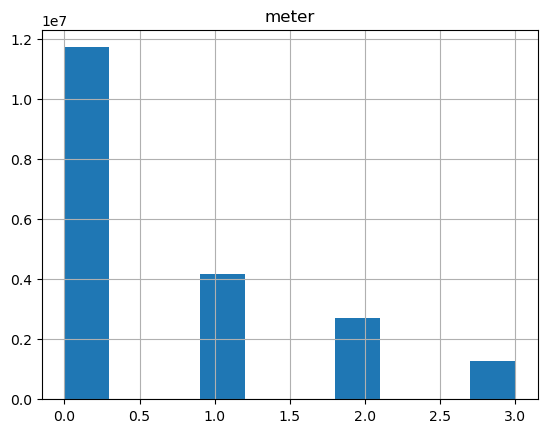

In [15]:
# Visualise meter type distribution
train_df.hist(column="meter")

In [30]:
# Meter type '0' is electricity
target_meter = 0 
X, y = create_X_y(train_df, target_meter=target_meter)
print('Length: ', len(X))

Length:  11714696


### Splitting
Semantically, treat 'validation' here as 'test', as I am only training and testing. The size of the splits were arbitrarily chosen based somewhat on what I had discovered my laptop to handle! 

In [31]:
# Sample dataframe
trainsize = 6000000
valsize = 3000000

X_train = X.iloc[:trainsize]
y_train = y[:trainsize]

X_val = X.iloc[trainsize:trainsize + valsize]
y_val = y[trainsize:trainsize + valsize]

del X, y
gc.collect()

510

### Initial decision tree
This is a regression problem with time series, so I choose to see how a decision tree regressor performs. 

In [34]:
%%time
# Decision tree
reg_dt = tree.DecisionTreeRegressor(random_state=1)
reg_dt.fit(X_train, y_train)

CPU times: user 1min 35s, sys: 920 ms, total: 1min 36s
Wall time: 1min 36s


DecisionTreeRegressor(random_state=1)

In [37]:
print('Validation score: ', reg_dt.score(X_val, y_val))

# Without shuffling, validation score was 0.691539

Validation score:  0.8617923474614327


Here, as learned in the training course, I want to see what a good maximum depth should be. I could maybe have looked deeper, but my poor laptop was about to take off...

In [39]:
bestdepth=-1
bestscore=0
max_depth = 15

for i in range(max_depth):
    reg = tree.DecisionTreeRegressor(max_depth=i+1, random_state=2)
    reg.fit(X_train, y_train)
    trainscore = reg.score(X_train,y_train)
    valscore = reg.score(X_val, y_val)
    print('Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)

    if valscore>bestscore:
        bestscore=valscore
        bestdepth=i+1

print(bestdepth, bestscore)

Depth: 1 Train Score: 0.5239400651403099 Validation Score: 0.5239449127499332
Depth: 2 Train Score: 0.7338673087157892 Validation Score: 0.732773897897899
Depth: 3 Train Score: 0.7995178446969624 Validation Score: 0.7982735040044859
Depth: 4 Train Score: 0.8170982873938339 Validation Score: 0.8162269945292051
Depth: 5 Train Score: 0.8256760239867136 Validation Score: 0.8248669180274295
Depth: 6 Train Score: 0.8320450777955344 Validation Score: 0.8313578357113578
Depth: 7 Train Score: 0.8386406493277072 Validation Score: 0.8379961663306665
Depth: 8 Train Score: 0.8445084120658539 Validation Score: 0.8438911554184909
Depth: 9 Train Score: 0.8499767928019781 Validation Score: 0.849123759509318
Depth: 10 Train Score: 0.8567084607656266 Validation Score: 0.8553277777573658
Depth: 11 Train Score: 0.8637915679232155 Validation Score: 0.861792396372042
Depth: 12 Train Score: 0.8710955625119337 Validation Score: 0.8679953379310593
Depth: 13 Train Score: 0.8785623503597385 Validation Score: 0.87

### Random forests
I now want to see if a random forest perform better than our decision tree benchmark. It does on the order of 1% better.

In [40]:
# Random forest
reg_rf = ensemble.RandomForestRegressor(n_estimators=10, 
                                         max_depth=bestdepth, 
                                         random_state=1)
reg_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=10, random_state=1)

In [41]:
print('Validation score: ', reg_rf.score(X_val, y_val))

Validation score:  0.8913993870236129


I chose to use a different seed to search for a smaller maximum tree depth, to no avail. 

In [42]:
# Look for a smaller viable max depth
bestdepth=-1
bestscore=0
max_depth = 12

for i in range(3, max_depth):
    reg = ensemble.RandomForestRegressor(n_estimators=10, 
                                         max_depth=i+1, 
                                         random_state=2)
    reg.fit(X_train, y_train)
    trainscore = reg.score(X_train,y_train)
    valscore = reg.score(X_val, y_val)
    print('Depth:', i+1, 'Train Score:', trainscore, 'Validation Score:', valscore)

    if valscore>bestscore:
        bestscore=valscore
        bestdepth=i+1

print(bestdepth, bestscore)

Depth: 4 Train Score: 0.8173457766556471 Validation Score: 0.8164737095484683
Depth: 5 Train Score: 0.8262924052731369 Validation Score: 0.8254368491043762
Depth: 6 Train Score: 0.8324542394342798 Validation Score: 0.8317972573428376
Depth: 7 Train Score: 0.8395737663577152 Validation Score: 0.838961536486423
Depth: 8 Train Score: 0.8459838380014133 Validation Score: 0.8453487973523638
Depth: 9 Train Score: 0.8523065707155864 Validation Score: 0.8514474581760876
Depth: 10 Train Score: 0.8600258841480135 Validation Score: 0.8587775916367497
Depth: 11 Train Score: 0.8676484591813447 Validation Score: 0.8657349831465146
Depth: 12 Train Score: 0.8758026627706075 Validation Score: 0.8729059043502122
12 0.8729059043502122


In [43]:
del reg
gc.collect()

450

### Feature engineering
I later want to try a grid search for hyperparameter tuning, so first I see if there are any features I can remove to minimise the model. 

In [44]:
feature_importances = reg_rf.feature_importances_
sorted_idx = feature_importances.argsort()

feature_names = np.array(category_cols + feature_cols)

In [45]:
def plot_impurity_metric_features(feature_importances, sorted_idx, feature_names):
    y_ticks = np.arange(0, len(feature_names))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.barh(y_ticks, feature_importances[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()

Based on material in the training course, I have used both the impurity metric approach and the permutation method. 

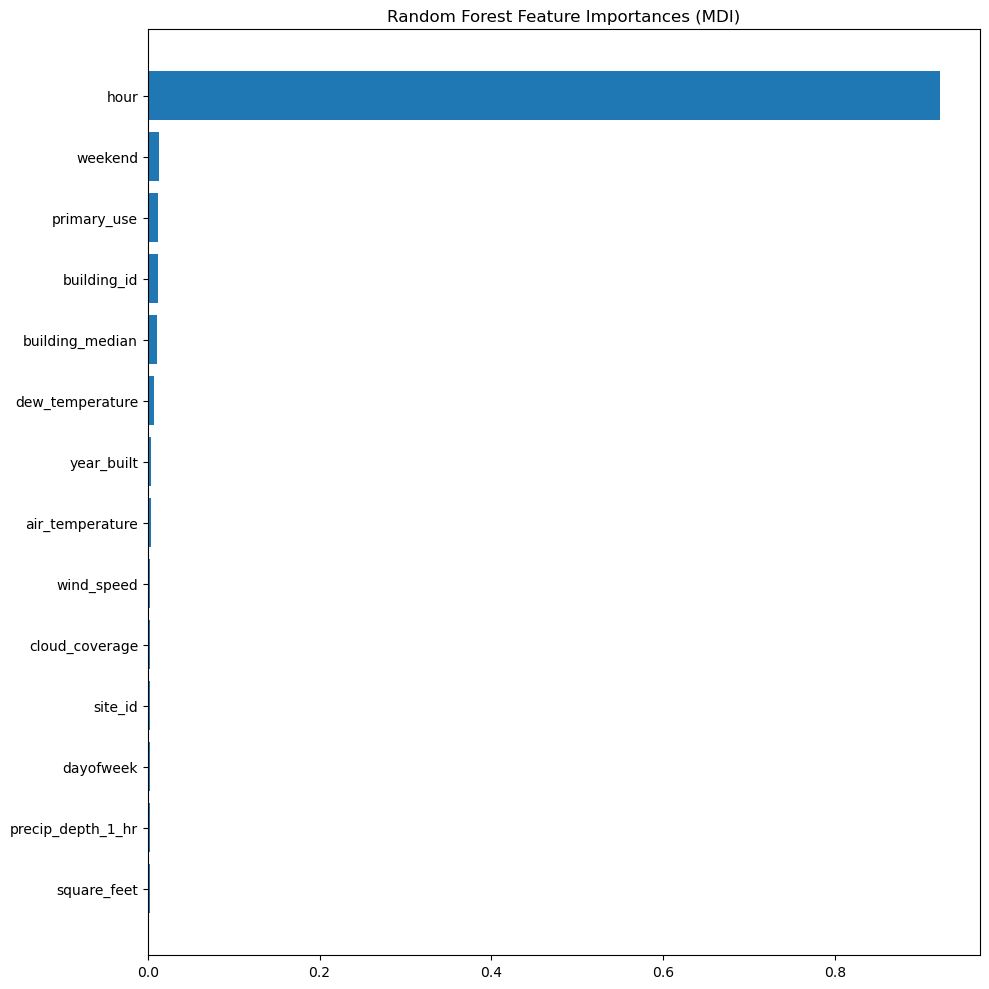

In [46]:
plot_impurity_metric_features(feature_importances, sorted_idx, feature_names)

In [47]:
result = permutation_importance(reg_rf, X_train, y_train, n_repeats=10, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

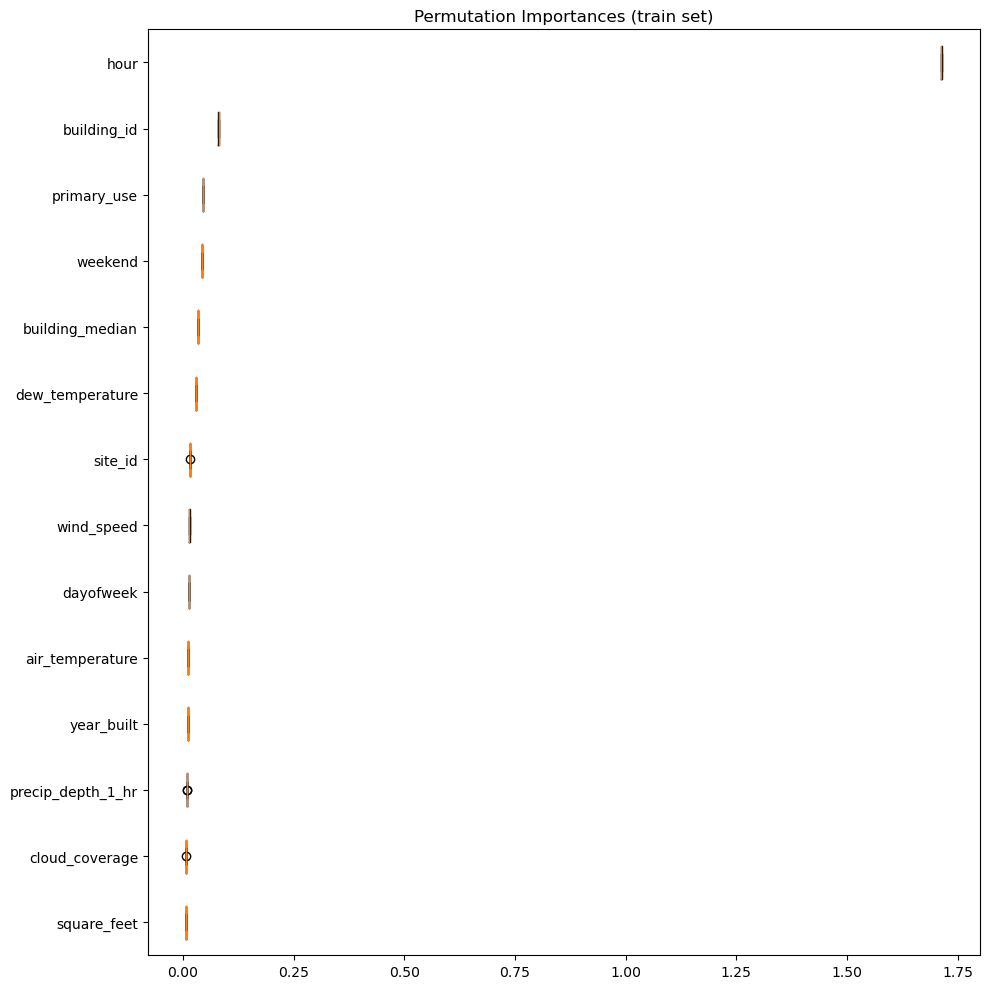

In [48]:
def plot_perm_importance(result, sorted_idx, feature_names):

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
    )
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.show()
    
plot_perm_importance(result, sorted_idx, feature_names)

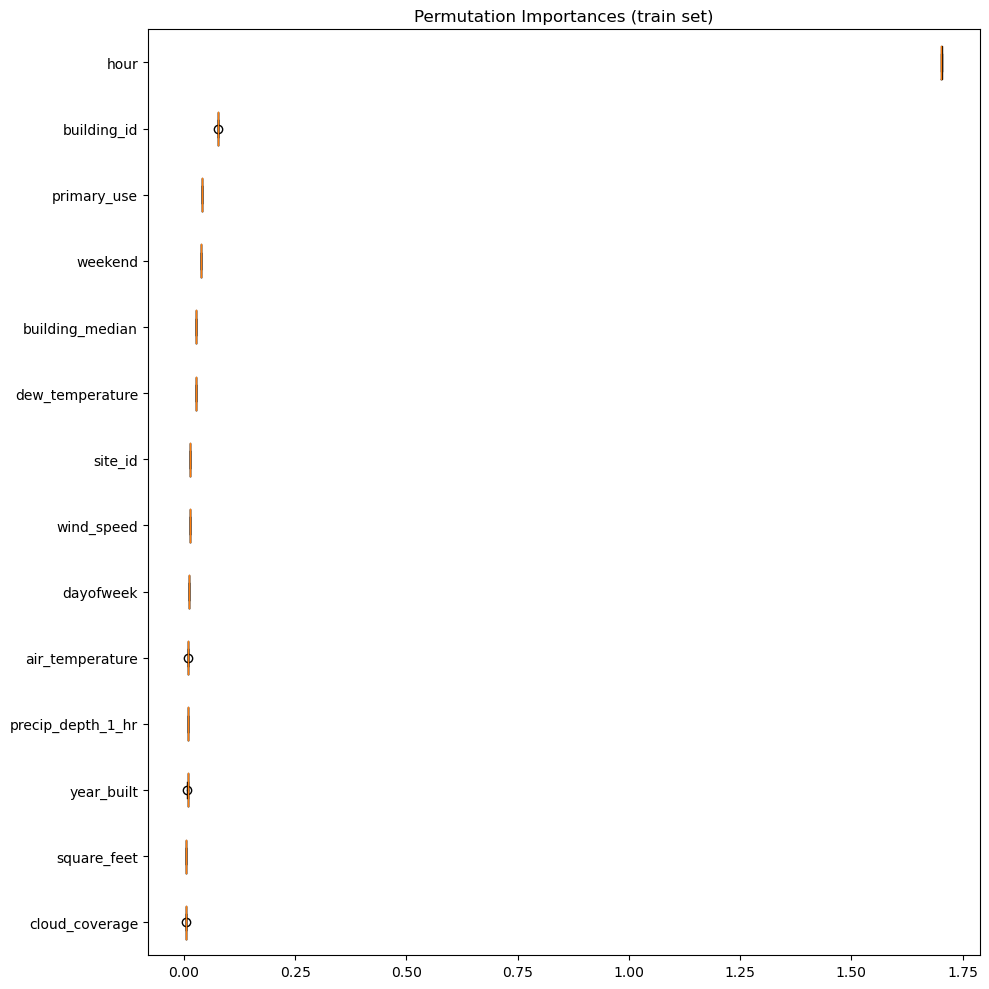

In [49]:
result = permutation_importance(reg_rf, X_val, y_val, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

plot_perm_importance(result, sorted_idx, feature_names)

Clearly, hour is a dominantly imoprtant feature. This makes me wonder what the performance would be like if I *only* used hour! 

I decided to remove the following features. Based on the above plot, these include everything less important than dew temperature. 

In [50]:
# Drop features to speed up grid search
dropcols = ['wind_speed', 'site_id', 'dayofweek', 'year_built', 
            'precip_depth_1_hr', 'cloud_coverage', 'square_feet', 'air_temperature']
X_train.drop(dropcols, axis=1)
X_val.drop(dropcols, axis=1)

,hour,weekend,building_median,dew_temperature,building_id,primary_use
6000000,21,0.0,3.177734,19.406250,930,2
6000001,13,0.0,4.339844,1.700195,1120,15
6000002,20,1.0,4.718750,6.699219,888,3
6000003,6,1.0,7.101562,13.898438,546,7
6000004,7,0.0,2.468750,11.000000,659,3
...,...,...,...,...,...,...
8999995,6,0.0,6.234375,10.601562,611,0
8999996,14,1.0,6.019531,16.093750,8,0
8999997,9,1.0,3.394531,3.300781,441,7
8999998,10,1.0,5.898438,11.703125,1286,11


### Hyperparameter tuning
Here, I use an arbitrarily constrained grid search to observe the trade-off of time against marginal improvements. I used all eight of my processors, and this took a long time for very little benefit! This is a valuable lesson for me to learn, though. With greater understanding of the dataset and of machine learning algorithms, I'll be able to develop a sense of when this might be worth doing or not. 

In [51]:
# Grid search
def grid_search_rf(X, y):
    reg = ensemble.RandomForestRegressor(max_depth=15, random_state=3)
    param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : [None, "sqrt", "log2"],
            "min_samples_split" : [1,2,4]
            }

    grid = GridSearchCV(reg, param_grid, scoring="r2", n_jobs=-1) # same scoring as RFRegressor

    grid.fit(X, y)

    return grid.best_score_ , grid.best_params_

In [54]:
gc.collect()

25641

In [55]:
best_score, best_params = grid_search_rf(X_train, y_train)

In [57]:
best_params

{'max_features': None, 'min_samples_split': 2, 'n_estimators': 30}

These were somewhat expected. Particularly the number of trees - I expect this needs to be around the 100 value for meaningful improvement, but I lacked the computing resource. 

In [58]:
reg_rf = ensemble.RandomForestRegressor(max_depth=15).set_params(**best_params)
reg_rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, max_features=None, n_estimators=30)

In [59]:
print('Validation score: ', reg_rf.score(X_val, y_val))

Validation score:  0.8922368507875279


## Closing remarks
### Results
After finding the best maximum depth in my decision tree to be 15 with a validation R2 score of 0.88166 (up from 0.86179 when no maximum depth was set on a different seed, and 0.69154 when the data wasn't shuffled before train-validation splitting), I used this depth to inform my random forest regressor.

The initial random forest R2 validation score was 0.89140. I then wished to perform a grid search, but to save on computing demand, I dropped some features that appeared meaningless.

After a grid search over the hyperparameters mentioned above, I find negligible improvement to an R2 validation score of 0.89224.

### Future exploration
I would like to have tried LightGBM, a tree based model with 'linear trees' that are good for extrapolating unseen data. This might be better for time series.

I should of course plot tiles of random buildings' validation prediction compared to actuals, although my Python is still limited. The way I shuffled the data would have made this difficult, too. Here, I shuffled data so that training isn't for different season/s than validation/test. An approach I would like to try is to use the first three weeks of each month as the training data, and the final week as the test set, which would make plotting the forecasted energy use easier. This overcomes the seasonal bias, and domain knowledge tells us that end of month doesn't impact energy use. 

Removing features should be done more rigorously, such as using Boruta algorithm (https://www.kaggle.com/code/residentmario/automated-feature-selection-with-boruta). 

With greater understanding and time I would like to try Bayesian optimization, (eg. https://www.kaggle.com/code/aitude/ashrae-hyperparameter-tuning). Here, I chose to observe the results of a grid search, which was still a great learning experience for me. 